In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from sentence_transformers import SentenceTransformer, util


/Users/az/opt/anaconda3/envs/argue-better/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: xlabel='WA', ylabel='Density'>

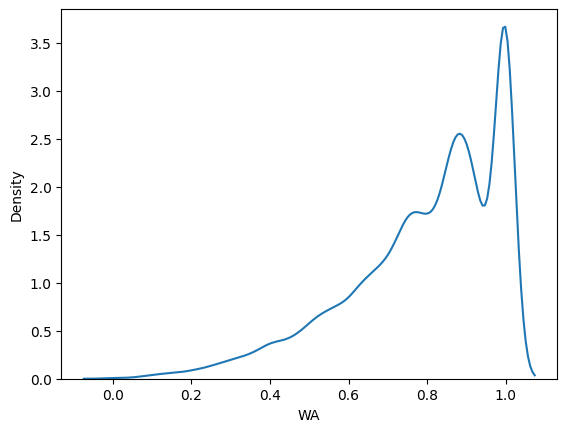

In [2]:
ibm = pd.read_csv("data/IBM_Debater_(R)_arg_quality_rank_30k/arg_quality_rank_30k.csv")
ibm = ibm[['argument', 'topic', 'WA', 'MACE-P']]
sns.kdeplot(ibm['WA'])

In [43]:

anns = dict()
essays = dict()
path = 'data/essays_all/'

Files = Path(path).glob('*.ann')
for file in Files:
        idx = int(str(file)[-7:-4])
        anns[idx] = pd.read_csv(file, sep='\t', header=None)

Files = Path(path).glob('*.txt')
for file in Files:
        with open(file, 'r') as f:
                idx = int(str(file)[-7:-4])
                essays[idx] = f.read()


In [4]:
import numpy as np
from sentence_transformers import SentenceTransformer, util

def get_sentence_similarity_matrix(sentences):
    model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    sentence_embeddings = model.encode(sentences, convert_to_tensor=True)
    cos_similarities = util.cos_sim(sentence_embeddings, sentence_embeddings)

    sim_matrix = cos_similarities.cpu().numpy()
    return sim_matrix

similarity_matrix = get_sentence_similarity_matrix(ibm['argument'].tolist())

In [8]:
with open('similarity_matrix.npy', 'wb') as f:
    np.save(f, similarity_matrix)

In [3]:
with open('similarity_matrix.npy', 'rb') as f:
    similarity_matrix = np.load(f)

In [4]:
topic_df_dict = dict()
for topic in ibm['topic'].unique():
    topic_df_dict[topic] = ibm[ibm.topic == topic].drop('topic', axis=1)

Construct the dataset:
1. under the same category
2. find the most similar ones
3. retrieve the one with the highest scores (WA + MACE-P)

In [9]:
def get_best_example(df, similarity_matrix, num_args=100):
    top_args = []
    for idx, row in df.iterrows():
        df = topic_df_dict[row['topic']]
        cos_similarities = similarity_matrix[idx][df.index.to_list()]
        df = df.reset_index(drop=True)
        most_similar_indices = np.argsort(-1*cos_similarities)[:num_args]
        most_similar_arguments = pd.DataFrame([df.iloc[i] 
                                               for i in most_similar_indices])
        top_arg = most_similar_arguments.sort_values(by=['WA', 'MACE-P'], 
                                                        ascending= [False, False]
                                                        )

        top_args.append(top_arg.iloc[0]['argument'])
        
    return top_args
#ibm.apply(lambda row: find_closest_better(row), axis=1)
best_examples = get_best_example(ibm, similarity_matrix)


SyntaxError: invalid syntax (438768609.py, line 13)

In [92]:
best_examples

['marriage is an outdated tradition that does not account for our changing society.',
 'a multi party system would ensure more people get their viewpoint taken into account.',
 'zero-tolerance policy in schools teaches students responsibility and respect and should be adopted']

In [21]:
a = topic_df_dict['We should abandon marriage'].index.to_list()